Este notebook faz parte de um projeto desenvolvido para uma **gravadora**, com o objetivo de identificar os fatores que influenciam o sucesso de músicas em plataformas como **Spotify, Deezer e Apple Music**. O foco está na **validação de hipóteses** para apoiar o lançamento de um novo artista no mercado.

---

## Origem dos Dados

Os dados foram inicialmente tratados e unificados no **BigQuery** a partir de três arquivos CSV distintos contendo:
- Informações de desempenho no Spotify (`track_in_spotify`)
- Desempenho em plataformas concorrentes (`track_in_competition`)
- Características técnicas das faixas (`track_technical_info`)

Após tratamento (remoção de duplicatas, criação de colunas derivadas, classificação por quartis usando `NTILE(4)`, e união em uma tabela única), o resultado foi exportado como o arquivo **`track_total_info.csv`**, que é a base usada neste notebook.

---

## Objetivos

- **Validar hipóteses** levantadas pela gravadora com base nos dados disponíveis
- Identificar **correlações estatísticas relevantes**
- Testar modelos de **regressão linear**
- Fornecer **recomendações baseadas em dados** para orientar decisões estratégicas

---

## Hipóteses Avaliadas

1. Músicas com BPM mais altos geram mais streams
2. Músicas populares no Spotify também são populares em Deezer e Apple Music
3. A presença em playlists está relacionada ao número de streams
4. Artistas com mais músicas têm mais streams
5. Características técnicas da música influenciam o sucesso
6. Músicas lançadas em 2023 mantêm os mesmos padrões de popularidade
7. Músicas com colaborações (feat) têm mais streams do que faixas solo

---

## Estrutura do Notebook

- Importação de bibliotecas e dados
- Análise exploratória (EDA) e visualizações
- Testes estatísticos: Pearson, Spearman, Mann-Whitney
- Regressões lineares simples e múltiplas
- Interpretação dos resultados e recomendações finais

---

**Projeto Completo no GitHub**  
Para acessar os dados, scripts SQL, arquivos auxiliares, dashboard e ficha técnica, visite:  
🔗 [https://github.com/cristianethiel/streaming_musical](https://github.com/cristianethiel/streaming_musical)

---



# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, mannwhitneyu # Teste de Hipótese e Significância
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression  # Regressão Linear
from sklearn.model_selection import train_test_split  # Função para dividir dados em Treino e Teste
from sklearn.metrics import r2_score  # Métrica R² para avaliar o desempenho de modelos de regressão
import statsmodels.api as sm  # Statsmodels para análise estatística
import statsmodels.formula.api as smf  # Statsmodels para análise estatística com fórmulas

# Dados

In [2]:
df = pd.read_csv('dataset/track_total_info.csv')
df.head()

,track_id,track_name,artist_name,artist_count,release_date,bpm,key_note,mode,danceability_pct,valence_pct,...,speechiness_pct,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,streams,total_playlists,total_charts
0,7477767,Evergreen (You Didn t Deserve Me A,Omar Apollo,1,2022-04-08,82,A,Major,70,31,...,4,2499,0,70,0,49,0,227918678,2618,0
1,8186517,Infinity,Jaymes Young,1,2017-06-23,122,B,Minor,67,50,...,4,4375,0,24,0,396,0,888046992,4795,0
2,8553734,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022-11-03,92,C#,Major,80,81,...,6,573,0,2,0,7,0,73513683,582,0
3,4487193,"Paulo Londra: Bzrp Music Sessions, Vol. 23","Bizarrap, Paulo Londra",2,2022-04-25,96,Ausente,Major,61,32,...,9,928,0,19,0,7,0,164163229,954,0
4,6347306,Dua Lipa,Jack Harlow,1,2022-05-06,158,B,Major,83,41,...,8,1992,0,35,0,3,0,150500965,2030,0


# Análise Exploratória de Dados (EDA)

## Histograma para Distribuição de Streams

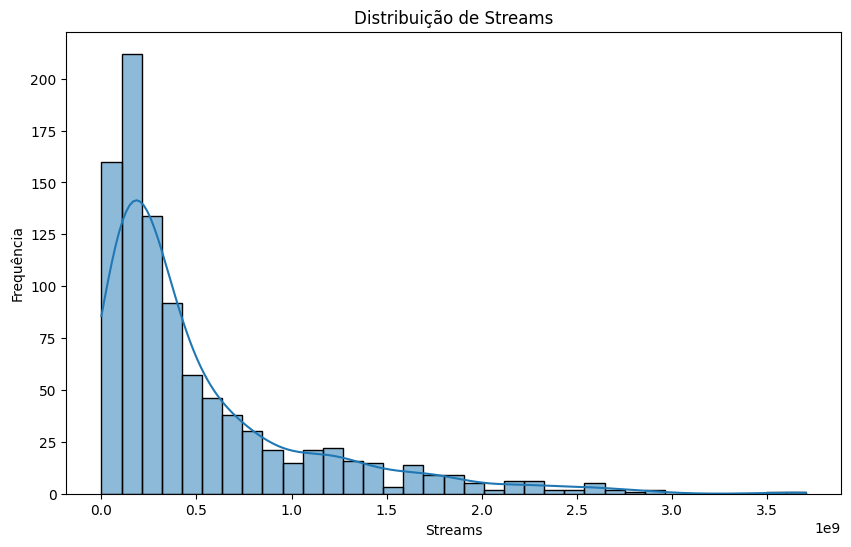

In [3]:
# Histograma para ver a distribuição de streams
plt.figure(figsize=(10, 6))
sns.histplot(df['streams'], kde=True)
plt.title('Distribuição de Streams')
plt.xlabel('Streams')
plt.ylabel('Frequência')
plt.show()

## Boxplot para Identificação de Outliers

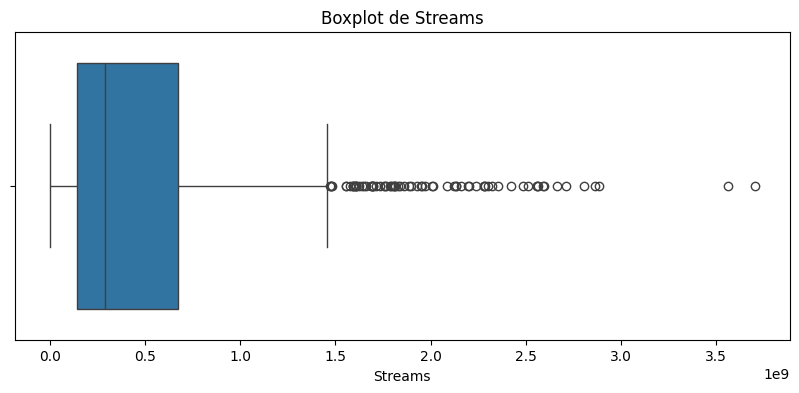

In [4]:
# Boxplot para visualizar mediana, quartis e outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['streams'])
plt.title('Boxplot de Streams')
plt.xlabel('Streams')
plt.show()

### Análise da Distribuição da Variável Streams

O histograma e o boxplot da variável streams revelam informações importantes sobre os dados de popularidade das músicas:

1.  **Concentração e Cauda Longa:** O histograma mostra claramente que a distribuição é **assimétrica à direita**. A frequência de músicas é alta para contagens de streams mais baixas e diminui gradualmente, formando uma cauda longa para valores extremamente altos.

2.  **Presença de Outliers:** O boxplot confirma essa assimetria e destaca a presença de **muitos outliers**, ou seja, músicas com um número de streams significativamente maior do que a maioria.

A não normalidade da distribuição de streams é um fator importante para as análises a seguir. Por isso, a escolha de testes como a **Correlação de Spearman** e o **Mann-Whitney U**, garantindo análises mais adequadas e confiáveis para este conjunto de dados.

*Nota: A exploração visual inicial e mais abrangente desse dataset foi conduzida utilizando o Power BI e mais detalhes estão na ficha técnica*

# Validação de Hipóteses

## Validação de Hipóteses (Correlação e Significância)

#### 1. A presença de uma música em um maior número de playlists está correlacionada com um maior número de streams. Esse padrão também acontece com as músicas lançadas em 2023? 

In [5]:
# apenas dados de 2023
df_2023 = df[df['release_date'] >= '2023-01-01']
df_2023.head()

# calcula a correlação de Pearson
pearson_corr, pearson_p_value = pearsonr(df_2023['total_playlists'], df_2023['streams'])
print("Correlação de Pearson:", pearson_corr)
print("Valor p de Pearson:", pearson_p_value)

# calcula a correlação de Spearman
spearman_corr, spearman_p_value = spearmanr(df_2023['total_playlists'], df_2023['streams'])
print("Correlação de Spearman:", spearman_corr)
print("Valor p de Spearman:", spearman_p_value)

Correlação de Pearson: 0.7846061223112557
Valor p de Pearson: 9.315420771795942e-38
Correlação de Spearman: 0.6538501800001046
Valor p de Spearman: 1.0228508752911913e-22


A correlação de Pearson (0.7846) indica uma relação forte entre as variáveis. A correlação de Spearman (0.6539) indica uma relação moderada, mas ainda significativa. Mesmo para músicas lançadas em 2023 há uma associação significativa entre o número de playlists e o número de streams.

#### 2. Músicas com colaborações (feat) têm, em média, mais streams do que músicas solo?  

In [6]:
# Hipótese nula (H₀): as distribuições de streams são iguais entre músicas com e sem colaboração
# Hipótese alternativa (H₁): as distribuições são diferentes

# separa as amostras com base na quantidade de artistas na faixa
solo = df[df['artist_count'] == 1]['streams']
colab = df[df['artist_count'] > 1]['streams']

# Teste Mann-Whitney
u_stat, p_val = mannwhitneyu(colab, solo, alternative='two-sided')

print("Estatística U:", u_stat)
print("p-valor:", p_val)

Estatística U: 88309.0
p-valor: 7.754405960490764e-06


O teste retornou uma estatística U = 88.309,0 e um p-valor muito baixo (7.75e-06), indicando que a diferença observada é estatisticamente significativa. O resultado rejeita a hipótese nula e conclui que músicas com colaborações tendem a ter, em média, mais streams do que músicas solo.

## Validação das Hipóteses com Correlação de Spearman

#### 1. Músicas com BPM mais altos fazem mais sucesso em termos de número de streams no Spotify.

In [7]:
# Calcula a correlação de Pearson
pearson_corr, pearson_p_value = pearsonr(df['bpm'], df['streams'])
print("Correlação de Pearson:", pearson_corr)
print("Valor p de Pearson:", pearson_p_value)

# Calcula a correlação de Spearman
spearman_corr, spearman_p_value = spearmanr(df['bpm'], df['streams'])
print("Correlação de Spearman:", spearman_corr)
print("Valor p de Spearman:", spearman_p_value)

Correlação de Pearson: -0.0018790993799330281
Valor p de Pearson: 0.953899177125793
Correlação de Spearman: 0.0033489076889134835
Valor p de Spearman: 0.9179389664055835


As correlações de Pearson (-0.0019) e Spearman (0.0033) entre BPM e número de streams foram próximas de zero, com p-valores altos (0.95 e 0.91, respectivamente). Indica ausência de relação significativa entre o ritmo da música e sua popularidade em streams.

#### 2. As músicas mais populares no ranking do Spotify também possuem um comportamento semelhante em outras plataformas, como a Deezer.

In [8]:
# Correlação de Pearson
pearson_corr_deezer, p_pearson_deezer = pearsonr(df['in_spotify_charts'], df['in_deezer_charts'])
print("Spotify x Deezer - Pearson:", pearson_corr_deezer, "| p:", p_pearson_deezer)

pearson_corr_apple, p_pearson_apple = pearsonr(df['in_spotify_charts'], df['in_apple_charts'])
print("Spotify x Apple Music - Pearson:", pearson_corr_apple, "| p:", p_pearson_apple)

# Correlação de Spearman
spearman_corr_deezer, p_spearman_deezer = spearmanr(df['in_spotify_charts'], df['in_deezer_charts'])
print("Spotify x Deezer - Spearman:", spearman_corr_deezer, "| p:", p_spearman_deezer)

spearman_corr_apple, p_spearman_apple = spearmanr(df['in_spotify_charts'], df['in_apple_charts'])
print("Spotify x Apple Music - Spearman:", spearman_corr_apple, "| p:", p_spearman_apple)

Spotify x Deezer - Pearson: 0.6049180441816912 | p: 8.799955540386866e-96
Spotify x Apple Music - Pearson: 0.5523668558379233 | p: 6.574996093401958e-77
Spotify x Deezer - Spearman: 0.5915664690671503 | p: 1.1770971608511999e-90
Spotify x Apple Music - Spearman: 0.5216643567124445 | p: 2.3794784325329257e-67


As correlações entre os rankings do Spotify e os das outras plataformas foram moderadas e significativas (Pearson entre 0.55 e 0.60, p < 0.001). Indica que músicas populares no Spotify tendem a apresentar desempenho semelhante no Deezer e na Apple Music.

#### 3. A presença de uma música em um maior número de playlists está correlacionada com um maior número de streams.

In [9]:
# Correlação de Pearson
pearson_corr, pearson_p_value = pearsonr(df['total_playlists'], df['streams'])
print("Correlação de Pearson:", pearson_corr)
print("Valor p de Pearson:", pearson_p_value)

# Correlação de Spearman
spearman_corr, spearman_p_value = spearmanr(df['total_playlists'], df['streams'])
print("Correlação de Spearman:", spearman_corr)
print("Valor p de Spearman:", spearman_p_value)

Correlação de Pearson: 0.7831585496360848
Valor p de Pearson: 1.3223290459161239e-197
Correlação de Spearman: 0.8325022872445899
Valor p de Spearman: 4.100628706175773e-245


A correlação entre o número de playlists e os streams é forte e significativa (Pearson = 0.78; Spearman = 0.83; p < 0.001). Indica que músicas incluídas em mais playlists tendem a alcançar um número maior de reproduções.

#### 4. Artistas com um maior número de músicas no Spotify têm mais streams.

In [10]:
# conta o número de músicas por artista
artist_track_count = df.groupby('artist_name')['track_name'].count().reset_index()
artist_track_count.rename(columns={'track_name': 'num_tracks'}, inplace=True)

# conta número de streams por artista
artist_streams = df.groupby('artist_name')['streams'].sum().reset_index()

# junta os dois DataFrames
artist_data = pd.merge(artist_track_count, artist_streams, on='artist_name')

# calcula a Correlação de Pearson
pearson_corr, pearson_p_value = pearsonr(artist_data['num_tracks'], artist_data['streams'])
print("Correlação de Pearson:", pearson_corr)
print("Valor p de Pearson:", pearson_p_value)

# alcula a Correlação de Spearman
spearman_corr, spearman_p_value = spearmanr(artist_data['num_tracks'], artist_data['streams'])
print("Correlação de Spearman:", spearman_corr)
print("Valor p de Spearman:", spearman_p_value)

Correlação de Pearson: 0.7789210872010053
Valor p de Pearson: 2.009435127462658e-132
Correlação de Spearman: 0.4479598012682077
Valor p de Spearman: 3.720336246139573e-33


Ambas as análises (Pearson e Spearman) mostraram que existe uma correlação positiva entre o número de músicas de um artista e o número de streams. A correlação de Pearson foi de 0.779, indicando uma relação moderada a forte, enquanto a correlação de Spearman foi de 0.448, indicando uma correlação moderada, embora não tão forte. Ambos os valores p são extremamente baixos, o que indica que a correlação é estatisticamente significativa.

### 5. As características da música influenciam o sucesso em termos de número de streams no Spotify.

In [11]:
# características da música
selected_features = ['danceability_pct', 'valence_pct', 'energy_pct', 'acousticness_pct', 
                     'instrumentalness_pct', 'liveness_pct', 'speechiness_pct']

# cria um dicionário para armazenar correlações
correlation_results = {}

# faz um loop para calcular a correlação de Pearson e Spearman para cada variável
for feature in selected_features:
    pearson_corr, pearson_p_value = pearsonr(df[feature], df['streams'])
    spearman_corr, spearman_p_value = spearmanr(df[feature], df['streams'])
    
    correlation_results[feature] = {
        'Pearson': (pearson_corr, pearson_p_value),
        'Spearman': (spearman_corr, spearman_p_value)
    }

# mostra os resultados
for feature, values in correlation_results.items():
    print(f"Correlação entre {feature} e Streams:")
    print(f"  Pearson: {values['Pearson'][0]} (p-valor: {values['Pearson'][1]})")
    print(f"  Spearman: {values['Spearman'][0]} (p-valor: {values['Spearman'][1]})")
    print("-" * 40)

Correlação entre danceability_pct e Streams:
  Pearson: -0.10455835831850076 (p-valor: 0.0012570529711012743)
  Spearman: -0.07998506085481376 (p-valor: 0.013712434959944878)
----------------------------------------
Correlação entre valence_pct e Streams:
  Pearson: -0.04255066858753706 (p-valor: 0.19030587054986656)
  Spearman: -0.04151134572006726 (p-valor: 0.20137027114968717)
----------------------------------------
Correlação entre energy_pct e Streams:
  Pearson: -0.02618772466670765 (p-valor: 0.4203524750581223)
  Spearman: -0.032593701785431264 (p-valor: 0.3158513913504586)
----------------------------------------
Correlação entre acousticness_pct e Streams:
  Pearson: -0.004256113265080093 (p-valor: 0.8958220210958316)
  Spearman: -0.059553762941070135 (p-valor: 0.06668164629709458)
----------------------------------------
Correlação entre instrumentalness_pct e Streams:
  Pearson: -0.04396750592438008 (p-valor: 0.17595168502508815)
  Spearman: -0.003843600534147661 (p-valor: 

As características danceability speechiness têm correlação negativa e significativa com volume de streams, o que pode indicar que músicas mais dançantes ou com mais vocais tendem a não ser as mais populares. Por outro lado, valence, energy e acousticness têm correlação muito baixa com o volume dos streams, indicando pouca influência direta sobre a popularidade. Além disso, instrumentalness e liveness também mostram uma relação fraca com streams.

## Resumo: Validação das Hipóteses e Análises de Correlação

<p style="color:#0078D4;">1. Hipótese: BPM e Sucesso em Streams</p>
A análise de correlação entre BPM e o número de streams revelou ausência de relação significativa, com correlações próximas de zero tanto para Pearson (-0.0019) quanto para Spearman (0.0033), e valores p elevados (p > 0.9). Isso indica que o ritmo da música (BPM) não é um fator relevante para a popularidade em termos de streams.

<p style="color:#0078D4;">2. Hipótese: Popularidade Cruzada Entre Plataformas</p>
Existe uma correlação moderada e significativa entre a popularidade das músicas no Spotify e sua presença nas plataformas Deezer e Apple Music. As correlações de Pearson (0.55 a 0.60) e Spearman indicam que músicas populares no Spotify tendem a apresentar um desempenho semelhante nas outras plataformas, confirmando a sinergia entre os rankings dessas plataformas.

<p style="color:#0078D4;">3. Hipótese: Impacto das Playlists nos Streams</p>
A relação entre o número de playlists em que a música está presente e o número de streams é forte e significativa, com correlações de Pearson (0.78) e Spearman (0.83). Isso confirma a influência positiva das playlists sobre a popularidade das músicas, indicando que a inclusão em playlists é um fator determinante para o sucesso no Spotify.

<p style="color:#0078D4;">4. Hipótese: Artistas com Mais Músicas Têm Mais Streams</p>
A análise de correlação entre o número de músicas de um artista e o número total de streams revelou uma correlação positiva moderada a forte (Pearson = 0.779 e Spearman = 0.448), com valores p muito baixos, sugerindo uma relação significativa. Isso significa que artistas com um catálogo maior de músicas tendem a acumular mais streams, embora a relação não seja linear (Pearson > Spearman).

<p style="color:#0078D4;">5. Hipótese: Características da Música e Sucesso nos Streams</p>
Todas as características, quando analisadas de maneira individual, apresentam relações negativas e muito fracas com o número de streams. Além disso, o p-valor de várias delas é alto, o que sugere que as correlações observadas podem não ser estatisticamente significativas em termos de impacto real.

# Regressão Linear

#### 1. Músicas com BPM mais altos fazem mais sucesso em termos de número de streams no Spotify.

In [12]:
X = df['bpm'].values.reshape(-1, 1)  # BPM como variável independente - pode ser manipulada é móvel
Y = df['streams'].values  # Streams como variável dependente

# divide os dados em treino e teste (80% treino, 20% teste)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# cria o modelo de regressão linear usando a biblioteca sklearn
model = LinearRegression()

# treina o modelo nos dados de treino
model.fit(x_train, y_train)

# faz previsões nos dados de teste
y_pred = model.predict(x_test)

# avalia o modelo usando R²
r2 = r2_score(y_test, y_pred)
print(f"R² do modelo: {r2}")

R² do modelo: -0.002249283091609655


O modelo de regressão linear não foi capaz de explicar a variação nos streams a partir do BPM, com R² negativo (-0,002), o que indica pior desempenho que uma média simples. O BPM não tem relação linear com a quantidade de streams.

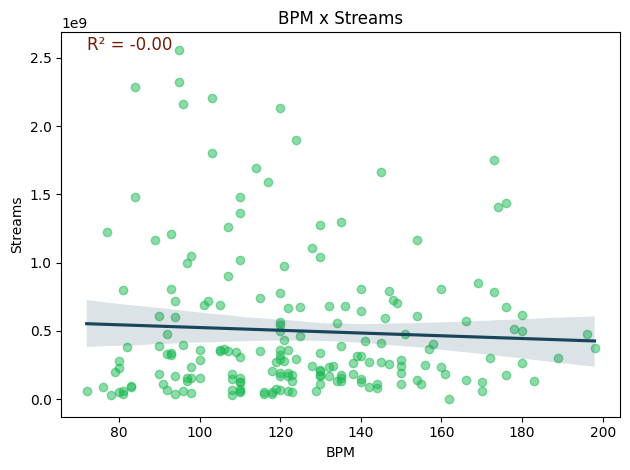

In [13]:
# Gráfico com cores personalizadas
sns.regplot(
    x=x_test[:, 0],  # eixo X com os valores de teste da variável independente - matriz
    y=y_test,        # eixo Y com os valores reais da variável dependente 
    scatter_kws={'color': '#1db954', 'alpha': 0.5},  # configurações dos pontos
    line_kws={'color': '#18455b'}  # cor da linha de regressão
)

# Adicionando o R² no gráfico
plt.text(
    x=min(x_test)[0],                # posição X do texto (valor mínimo do eixo X)
    y=max(y_test),                   # posição Y do texto (valor máximo do eixo Y)
    s=f"R² = {r2:.2f}",              # texto com o valor do R² formatado com duas casas decimais
    fontsize=12,                     # tamanho da fonte
    color='#741d07'                  # cor do R²
)

# Título e rótulos dos eixos
plt.title("BPM x Streams")           # título do gráfico
plt.xlabel("BPM")                    # rótulo do eixo X
plt.ylabel("Streams")               # rótulo do eixo Y

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe o gráfico
plt.show()


Utilizei a biblioteca statsmodels para rodar o mesmo modelo de regressão linear simples com o objetivo de obter, além do R², os p-valores dos coeficientes. O p-valor indica se a relação entre a variável independente (BPM) e a variável dependente (Streams) é estatisticamente significativa.

Coef.: mostra o impacto do BPM nos Streams.

P>|t|: se for menor que 0.05, sugere que a variável BPM tem influência estatística relevante.

R-squared: indica a proporção da variabilidade em Streams explicada pelo BPM.

Essa abordagem é útil quando o foco é interpretar o modelo estatisticamente, além de apenas prever.

In [14]:
# Define X e Y
X = df['bpm']  # variável independente
Y = df['streams']  # variável dependente

# Adiciona a constante (intercepto)
X_const = sm.add_constant(X)

# Cria o modelo e ajusta aos dados
modelo = sm.OLS(Y, X_const).fit()

# Exibe o resumo com R², coeficientes e p-valores
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.003344
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.954
Time:                        08:14:38   Log-Likelihood:                -20475.
No. Observations:                 949   AIC:                         4.095e+04
Df Residuals:                     947   BIC:                         4.096e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.185e+08   8.27e+07      6.271      0.0

Neste modelo de regressão linear, o objetivo foi analisar a relação entre a variável independente **BPM** e a variável dependente **Streams**. O modelo foi ajustado utilizando os dados fornecidos e os principais resultados são os seguintes:

**1. R-squared (R²)**
- **R² = 0.000**: O valor de R² indica que **0% da variabilidade nos valores de Streams** é explicada pelo BPM no modelo. Isso sugere que o modelo de regressão não é capaz de capturar a relação entre essas duas variáveis, o que implica que o BPM não é um bom preditor para os Streams nesse conjunto de dados.

**2. P-valor**
- **P-valor para o BPM = 0.954**: O p-valor associado ao coeficiente de BPM é muito alto (acima de 0.05), o que significa que **não existe uma relação estatisticamente significativa entre BPM e Streams**. Em outras palavras, o valor de BPM não tem impacto substancial sobre a variável Streams, com base nos dados analisados.

**3. Coeficientes**
- **Interceptação (constante) = 5.185e+08**: Este valor representa a estimativa para a variável Streams quando o BPM é igual a zero. Embora o valor seja significativo em termos de magnitude, ele não tem relevância prática dado que o modelo não é significativo.
- **Coeficiente para BPM = -3.805e+04**: O coeficiente negativo sugere que, para cada aumento de 1 unidade no BPM, espera-se uma **diminuição de 38.050 streams**. No entanto, devido à falta de significância estatística (p-valor alto), não podemos confiar nessa relação.

**4. F-statistic e Prob (F-statistic)**
- **F-statistic = 0.003344** e **Prob (F-statistic) = 0.954**: O teste F testa a significância global do modelo. O valor p associado a essa estatística é muito alto, indicando que **o modelo como um todo não é significativo** e que a variável BPM não explica adequadamente os valores de Streams.

**5. Durbin-Watson**
- **Durbin-Watson = 1.759**: Este valor sugere que não há evidências de autocorrelação nos resíduos, o que é um bom sinal, pois significa que os erros do modelo são independentes.

**6. Conclusão**
O modelo de regressão linear simples entre BPM e Streams não apresenta bons resultados, como indicado pelo R² muito baixo e pelo p-valor alto. Isso sugere que a variável BPM **não tem um impacto estatisticamente significativo** sobre a variável Streams no contexto dos dados fornecidos.

#### 2. As músicas mais populares no ranking do Spotify também possuem um comportamento semelhante em outras plataformas, como a Deezer.

#### Spotify (X) vs Deezer (Y)  - Regressão Linear Simples
Nesse caso, a variável independente (X) é a posição no Deezer, porque queremos prever a posição no Spotify com base na posição no Deezer. Ou seja, a posição no Deezer é o fator que a gravadora acredita que influencia ou está relacionado com a posição no Spotify.

A variável dependente (Y) é a posição no Spotify, já que queremos saber se a popularidade no Deezer pode prever a popularidade no Spotify.

A análise com a regressão linear mostra se existe uma relação significativa entre essas duas variáveis e o valor do R² indica quanto da variação na posição no Spotify pode ser explicada pela posição no Deezer.

In [15]:
X = df['in_deezer_charts'].values.reshape(-1, 1) 
Y = df['in_spotify_charts'].values

# divide os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# cria o modelo de regressão linear
model = LinearRegression()

# treina o modelo
model.fit(x_train, y_train)

# faz previsões
y_pred = model.predict(x_test)

# avalia o modelo
r2 = r2_score(y_test, y_pred)
print(f"R² do modelo: {r2}")

R² do modelo: 0.4510903581210207


O R² do modelo foi de 0.4511, o que indica que aproximadamente 45% da variação na posição da música no Spotify pode ser explicada pela posição da música no Deezer. Existe uma relação moderada entre os rankings das duas plataformas, mas ainda existem outros fatores que influenciam o desempenho das músicas no Spotify que não são explicados pela posição no Deezer.

Ou seja, as músicas que estão bem posicionadas no Deezer tendem a ter um bom desempenho no Spotify, mas a explicação não é total (apenas 45%). Isso pode ser um bom ponto de partida para um modelo mais complexo ou uma análise de outras variáveis que também afetam o desempenho nas plataformas de streaming.

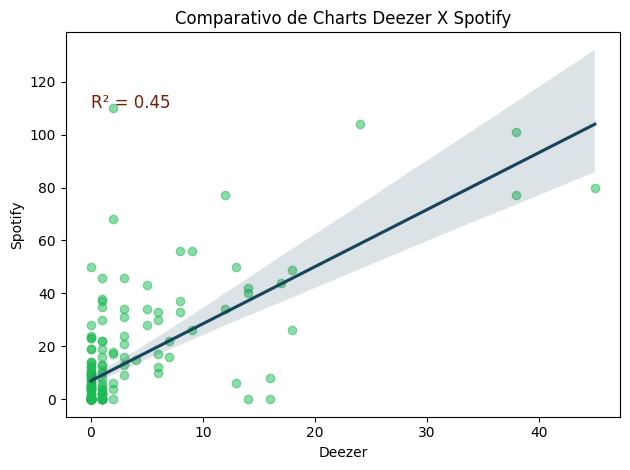

In [16]:
# Gráfico com cores personalizadas
sns.regplot(
    x=x_test[:, 0],  # eixo X com os valores de teste da variável independente - matriz
    y=y_test,        # eixo Y com os valores reais da variável dependente 
    scatter_kws={'color': '#1db954', 'alpha': 0.5},  # configurações dos pontos
    line_kws={'color': '#18455b'}  # cor da linha de regressão
)

# Adicionando o R² no gráfico
plt.text(
    x=min(x_test)[0],                # posição X do texto (valor mínimo do eixo X)
    y=max(y_test),                   # posição Y do texto (valor máximo do eixo Y)
    s=f"R² = {r2:.2f}",              # texto com o valor do R² formatado com duas casas decimais
    fontsize=12,                     # tamanho da fonte
    color='#741d07'                  # cor do R²
)

# Título e rótulos dos eixos
plt.title("Comparativo de Charts Deezer X Spotify")           # título do gráfico
plt.xlabel("Deezer")                    # rótulo do eixo X
plt.ylabel("Spotify")               # rótulo do eixo Y

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe o gráfico
plt.show()


#### Spotify (X) vs Apple Music (Y)  - Regressão Linear Simples

Mesma análise anterior, agora comparando com a plataforma Apple Music.

In [17]:
X = df['in_apple_charts'].values.reshape(-1, 1) 
Y = df['in_spotify_charts'].values

# divide os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# cria o modelo de regressão linear
model = LinearRegression()

# treina o modelo
model.fit(x_train, y_train)

# faz previsões
y_pred = model.predict(x_test)

# avalia o modelo
r2 = r2_score(y_test, y_pred)
print(f"R² do modelo: {r2}")

R² do modelo: 0.26346187784165187


Com base nos resultados anteriores, a relação entre as posições nos charts do Deezer e Spotify indica que o modelo consegue explicar cerca de 45% da variabilidade nos dados. Mais alto do que o R² de 0.263 obtido entre Apple Music e Spotify, que indica uma relação mais fraca. Portanto, a presença nos charts do Deezer parece ter uma influência mais forte nas posições do Spotify do que a presença no Apple Music.

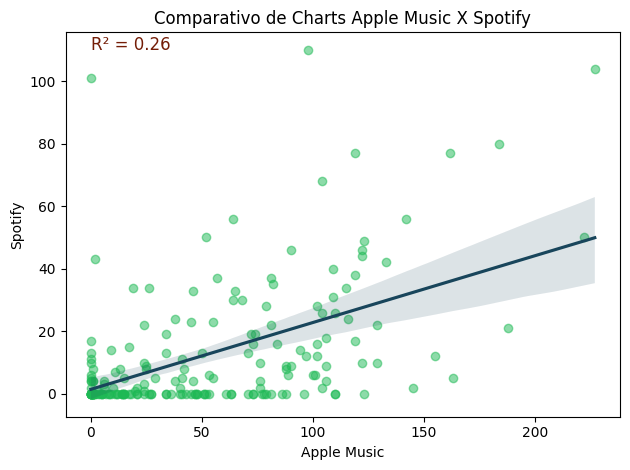

In [18]:
# Gráfico com cores personalizadas
sns.regplot(
    x=x_test[:, 0],  # eixo X com os valores de teste da variável independente - matriz
    y=y_test,        # eixo Y com os valores reais da variável dependente 
    scatter_kws={'color': '#1db954', 'alpha': 0.5},  # configurações dos pontos
    line_kws={'color': '#18455b'}  # cor da linha de regressão
)

# Adicionando o R² no gráfico
plt.text(
    x=min(x_test)[0],                # posição X do texto (valor mínimo do eixo X)
    y=max(y_test),                   # posição Y do texto (valor máximo do eixo Y)
    s=f"R² = {r2:.2f}",              # texto com o valor do R² formatado com duas casas decimais
    fontsize=12,                     # tamanho da fonte
    color='#741d07'                  # cor do R²
)

# Título e rótulos dos eixos
plt.title("Comparativo de Charts Apple Music X Spotify")           # título do gráfico
plt.xlabel("Apple Music")                    # rótulo do eixo X
plt.ylabel("Spotify")               # rótulo do eixo Y

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe o gráfico
plt.show()


### Regressão Linear Múltipla: Relação Entre Charts de Deezer, Apple Music e Spotify

In [19]:
# variáveis independentes (Deezer, Apple Music)
X = df[['in_deezer_charts', 'in_apple_charts']]  # multiplas variáveis
Y = df['in_spotify_charts']  # A variável dependente aqui é Spotify

# divide os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# modelo de regressão linear
model = LinearRegression()

# treina o modelo
model.fit(x_train, y_train)

# previsões
y_pred = model.predict(x_test)

# avalia o modelo
r2 = r2_score(y_test, y_pred)
print(f"R² do modelo de regressão linear múltipla: {r2}")


R² do modelo de regressão linear múltipla: 0.5141319569663312


O resultado R² = 0.5141 indica que aproximadamente 51.41% da variação nos charts do Spotify pode ser explicada pela combinação das variáveis de Deezer e Apple Music no modelo de regressão linear múltipla. Pelo que os resultados mostram, quando combinadas as variáveis de Deezer e Apple Music têm um impacto maior no modelo de regressão linear múltipla para prever o comportamento no Spotify. Então, quando consideradas isoladamente, essas plataformas não têm tanto poder explicativo sobre as classificações do Spotify. Mas, quando analisadas juntas, elas fornecem uma visão mais completa.

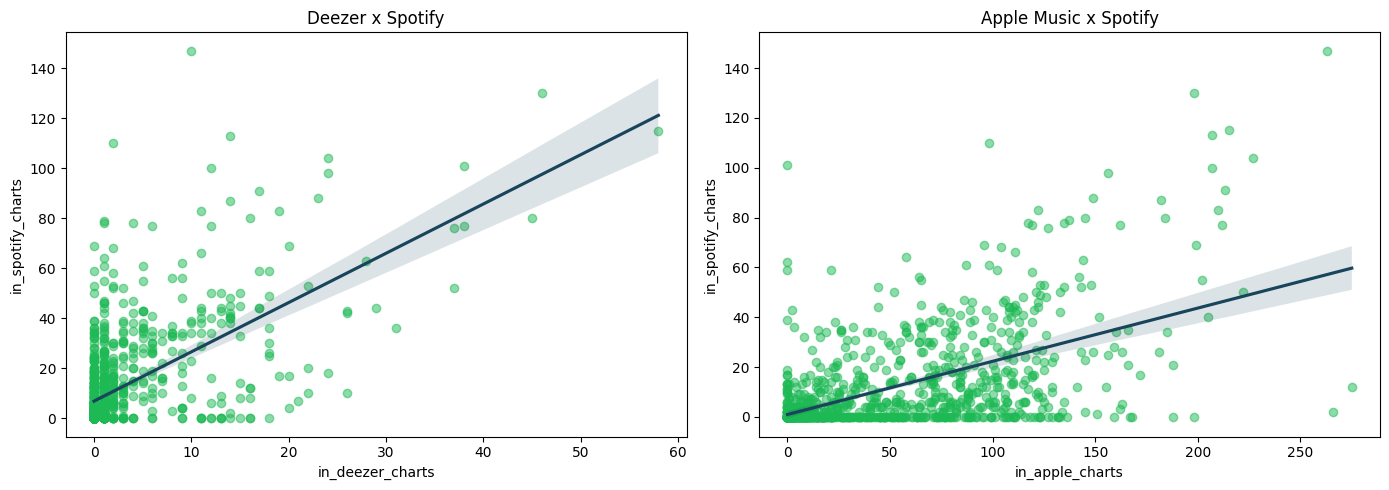

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Deezer
sns.regplot(
    x='in_deezer_charts', 
    y='in_spotify_charts', 
    data=df, 
    ax=axes[0], 
    scatter_kws={'color': '#1db954', 'alpha': 0.5}, 
    line_kws={'color': '#18455b'}
)
axes[0].set_title('Deezer x Spotify')

# Apple
sns.regplot(
    x='in_apple_charts', 
    y='in_spotify_charts', 
    data=df, 
    ax=axes[1], 
    scatter_kws={'color': '#1db954', 'alpha': 0.5}, 
    line_kws={'color': '#18455b'}
)
axes[1].set_title('Apple Music x Spotify')

plt.tight_layout()
plt.show()


In [21]:
# OLS Regression Results Para regressão múltipla (Deezer + Apple Music x Spotify)
X_multiple = sm.add_constant(df[['in_deezer_charts', 'in_apple_charts']])  # Adiciona a constante
Y = df['in_spotify_charts']

model_multiple = sm.OLS(Y, X_multiple).fit()  # Ajusta o modelo de OLS

# Exibe os resultados do modelo OLS
print(model_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:      in_spotify_charts   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     446.4
Date:                Thu, 24 Apr 2025   Prob (F-statistic):          2.98e-137
Time:                        08:14:39   Log-Likelihood:                -3854.6
No. Observations:                 949   AIC:                             7715.
Df Residuals:                     946   BIC:                             7730.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5391      0.655  

A análise de regressão múltipla realizada entre as posições nos charts do Deezer, Apple Music e Spotify revelou uma relação significativa entre essas variáveis. Os resultados mostram que:

1. A posição no Deezer tem um impacto considerável na posição no Spotify, com um coeficiente de 1.4997, o que significa que, para cada aumento de uma posição no Deezer, a posição no Spotify tende a subir em cerca de 1.5 posições, mantendo a posição no Apple Music constante. Este efeito é altamente significativo (p < 0.001).

2. A posição no Apple Music também afeta a posição no Spotify, mas com um impacto menor (coeficiente de 0.1450). Para cada aumento de uma posição no Apple Music, espera-se um aumento de 0.145 posições no Spotify, com um p-valor igualmente significativo.

3. O modelo apresenta um R² de 0.486, o que indica que cerca de 48.6% da variação na posição do Spotify é explicada pelas posições no Deezer e no Apple Music. Isso sugere uma relação forte, embora haja espaço para mais variáveis que poderiam melhorar a previsão.

4. O valor de Durbin-Watson (0.710) sugere a presença de autocorrelação nos resíduos, o que poderia indicar que o modelo não está completamente ajustado.

No geral, os resultados indicam que tanto o Deezer quanto o Apple Music têm uma influência importante sobre a posição no Spotify, com o Deezer mostrando um impacto mais forte. No entanto, a autocorrelação nos resíduos sugere que o modelo pode ser aprimorado com ajustes adicionais ou considerando outras variáveis explicativas.

#### 3. A presença de uma música em um maior número de playlists está correlacionada com um maior número de streams.

In [22]:
X = df['total_playlists'].values.reshape(-1, 1)  # playlists como variável independente - pode ser manipulada é móvel
Y = df['streams'].values  # Streams como variável dependente

# Divide os dados em treino e teste (80% treino, 20% teste)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Cria o modelo de regressão linear
model = LinearRegression()

# Treina o modelo nos dados de treino
model.fit(x_train, y_train)

# Faz previsões nos dados de teste
y_pred = model.predict(x_test)

# Avalia o modelo usando R²
r2 = r2_score(y_test, y_pred)
print(f"R² do modelo: {r2}")

R² do modelo: 0.5790567976963518


Como o R² é 0.58, isso indica que cerca de 58% da variação dos streams pode ser explicada pela quantidade de playlists em que a música aparece. Mostra que existe uma boa relação.

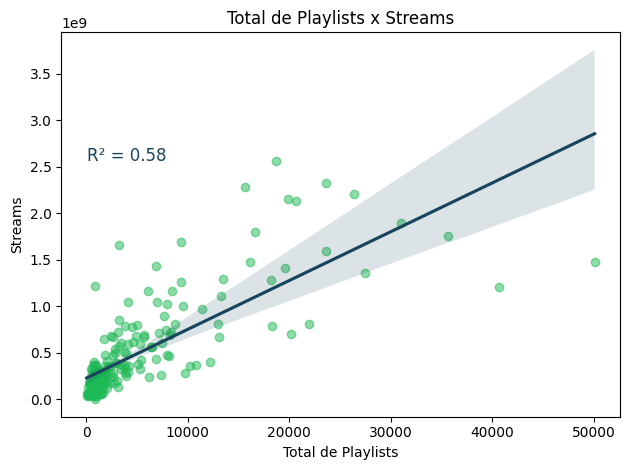

In [23]:
# Gráfico da regressão linear simples: Total de playlists x Streams
sns.regplot(
    x=x_test[:, 0],
    y=y_test,
    scatter_kws={'color': '#1db954', 'alpha': 0.5},  # bolinhas verdes
    line_kws={'color': '#18455b'}  # linha azul escura
)

# Adicionando o R² no gráfico
plt.text(x=min(x_test)[0], y=max(y_test), s=f"R² = {r2:.2f}", fontsize=12, color='#18455b')

# Título e rótulos
plt.title("Total de Playlists x Streams")
plt.xlabel("Total de Playlists")
plt.ylabel("Streams")

plt.tight_layout()
plt.show()


#### 4. Artistas com um maior número de músicas no Spotify têm mais streams.

In [24]:
# conta o número de músicas por artista
artist_track_count = df.groupby('artist_name')['track_name'].count().reset_index()
artist_track_count.rename(columns={'track_name': 'num_tracks'}, inplace=True)

# número de streams por artista
artist_streams = df.groupby('artist_name')['streams'].sum().reset_index()

# junta os dois DataFrames
artist_data = pd.merge(artist_track_count, artist_streams, on='artist_name')

# define X e Y
X = artist_data['num_tracks'].values.reshape(-1, 1)
Y = artist_data['streams'].values

# separa treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# treinar o modelo
model = LinearRegression()
model.fit(x_train, y_train)

# previsões
y_pred = model.predict(x_test)

# avaliao modelo com R²
r2 = r2_score(y_test, y_pred)
print(f"R² do modelo: {r2}")

R² do modelo: 0.29626772547543345


O valor do R² ficou em torno de 0.30, o que sugere que existe uma correlação fraca, mas ainda assim significativa: quanto mais músicas um artista tem no dataset, maior tende a ser o número de streams. Porém, isso não explica nem metade da variação nos streams, apenas 30%.

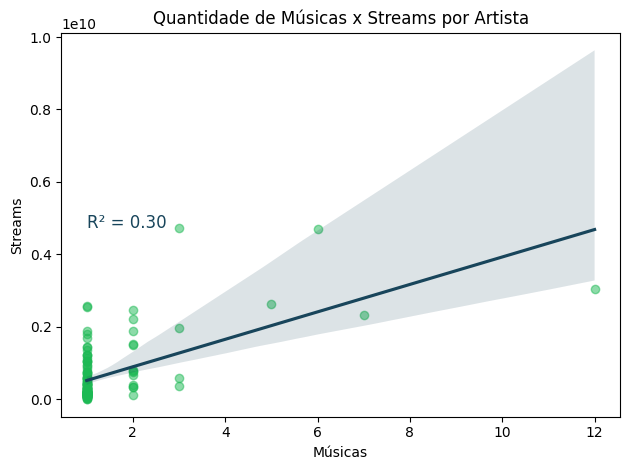

In [25]:
# Gráfico da regressão linear: Número de faixas x Streams por artista
sns.regplot(
    x=x_test[:, 0],
    y=y_test,
    scatter_kws={'color': '#1db954', 'alpha': 0.5},  # bolinhas verdes
    line_kws={'color': '#18455b'}  # linha da regressão azul escura
)

# inclui o R² no gráfico
plt.text(x=min(x_test)[0], y=max(y_test), s=f"R² = {r2:.2f}", fontsize=12, color='#18455b')

# título e rótulos
plt.title("Quantidade de Músicas x Streams por Artista")
plt.xlabel("Músicas")
plt.ylabel("Streams")

plt.tight_layout()
plt.show()


### 5. As características da música influenciam o sucesso em termos de número de streams no Spotify.

In [26]:
# características da música
X = df[['danceability_pct', 'valence_pct', 'energy_pct', 'acousticness_pct',
        'instrumentalness_pct', 'liveness_pct', 'speechiness_pct']]

# variável dependente = qtd de streams
Y = df['streams']

# treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# modelo
model = LinearRegression()
model.fit(x_train, y_train)

# Prever com os dados de teste
y_pred = model.predict(x_test)

# Avaliar com R²
r2 = r2_score(y_test, y_pred)
print(f"R² do modelo: {r2}")

R² do modelo: 0.021938716833325933


O R² tem valor muito baixo (0,02) o que indica que o modelo quase não consegue explicar a variação no número de streams com base nas características da música. Pode ser que:

1. As características talvez não influenciem os streams sozinhas
2. O sucesso de uma música provavelmente depende de outros fatores além das características técnicas
3. Pode ser que exista uma correlação entre algumas das características
4. Talvez as relações entre as características sejam muito complexas para esse tipo de análise

Para isso, vamos analisar os coeficientes (peso relativo de cada característica). Assim, vamos entender a força de cada característica.

In [27]:
# Adiciona a constante para o intercepto
X_sm = sm.add_constant(X)

# Cria o modelo OLS e ajusta
modelo = sm.OLS(Y, X_sm).fit()

# Mostra o resumo com os p-valores
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.974
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           0.000272
Time:                        08:14:39   Log-Likelihood:                -20461.
No. Observations:                 949   AIC:                         4.094e+04
Df Residuals:                     941   BIC:                         4.098e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  9.85e+08 

In [28]:
coeficientes = pd.DataFrame({
    'Variável': X.columns,
    'Coeficiente': model.coef_
})
print(coeficientes.sort_values(by='Coeficiente', ascending=False))

               Variável   Coeficiente
1           valence_pct  5.716731e+05
3      acousticness_pct -5.959428e+05
2            energy_pct -1.151826e+06
5          liveness_pct -3.188321e+06
4  instrumentalness_pct -4.113685e+06
0      danceability_pct -4.166540e+06
6       speechiness_pct -5.499720e+06


A característica Valence (positividade) é o único fator que mostra alguma correlação, influenciando o número de streams, mas ainda pouco. Todas as demais características têm influência negativa na previsão de streams. Pode ser que essas característcas não tenham mesmo peso no sucesso da música. Ou simplesmente que o modelo linear não é o mais adequado pra capturar essas relações.

Essa análise mostra que só olhar pras características técnicas da música não explica o sucesso dela (em número de streams). E mesmo quando alguma característica parece ter uma relação (como o valence), essa relação é fraca.

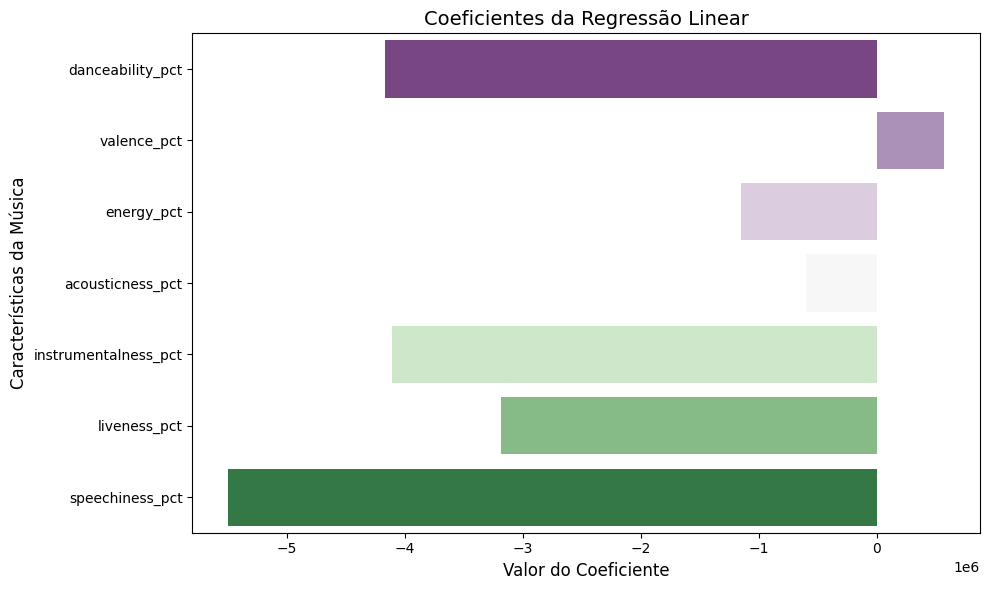

In [29]:
# fazer um gráfico para visualizar os coeficientes
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Variável', data=coeficientes, hue='Variável', palette='PRGn', legend=False)

# título e rótulos
plt.title('Coeficientes da Regressão Linear', fontsize=14)
plt.xlabel('Valor do Coeficiente', fontsize=12)
plt.ylabel('Características da Música', fontsize=12)

# exibe
plt.tight_layout()
plt.show()


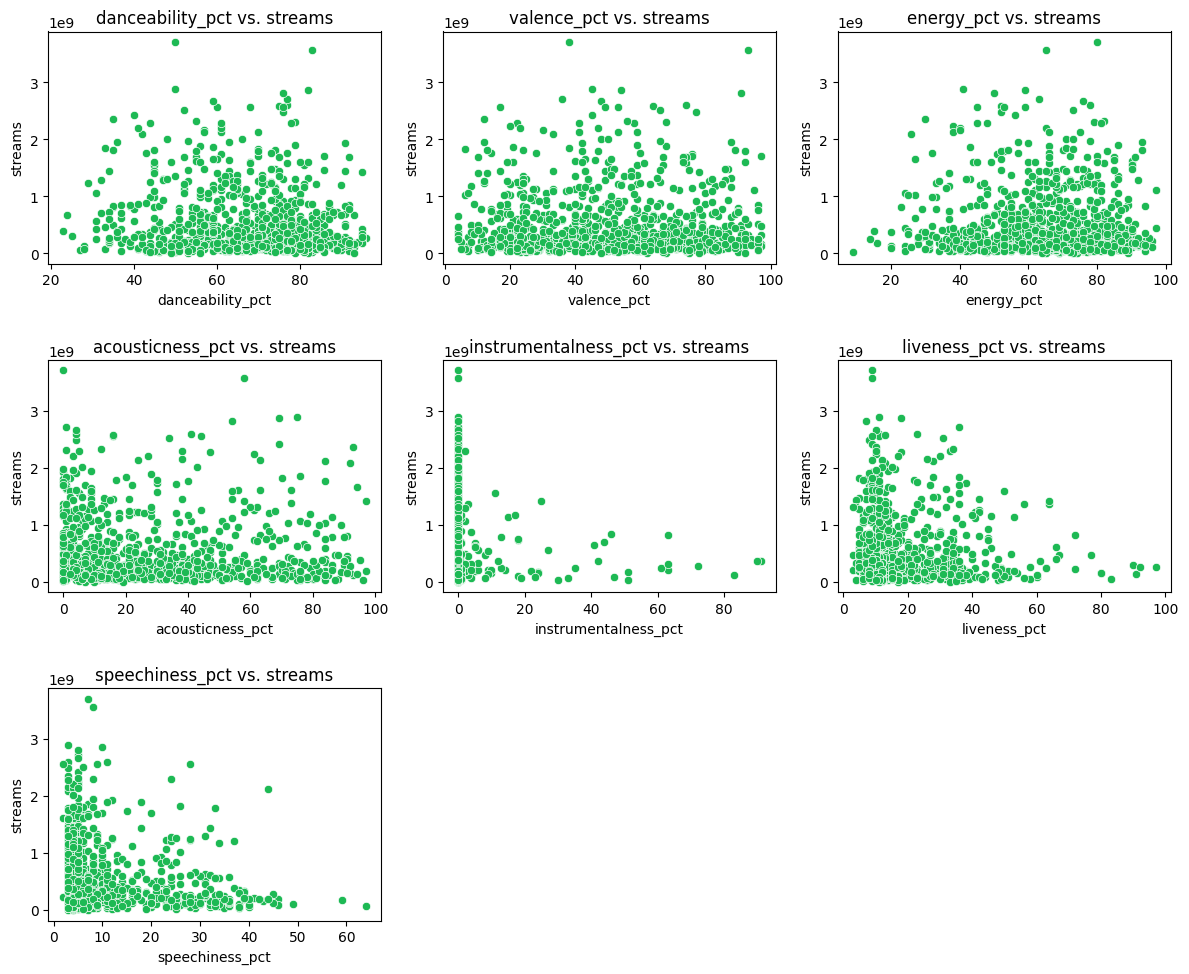

In [30]:
# características da música
caracteristicas = ['danceability_pct', 'valence_pct', 'energy_pct', 'acousticness_pct',
                   'instrumentalness_pct', 'liveness_pct', 'speechiness_pct']

# gráficos de dispersão para cada característica em relação aos streams
plt.figure(figsize=(12, 10))

# loop para criar os gráficos

for i, coluna in enumerate(caracteristicas, 1):
    plt.subplot(3, 3, i)  # Organiza os gráficos em uma grade 3x3
    sns.scatterplot(x=df[coluna], y=df['streams'], color='#1db954')
    plt.title(f'{coluna} vs. streams')
    plt.xlabel(coluna)
    plt.ylabel('streams')

plt.tight_layout()
plt.show()
